In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import imgaug as ia

In [2]:
df = pd.read_csv("data/training.csv")
df['Image'] = df['Image'].apply(lambda im:np.fromstring(im, sep=' '))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [4]:
df.count()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [5]:
df = df.dropna()

In [6]:
X = np.vstack(df['Image'].values)
X = X.astype(np.float32)

In [7]:
y = df[df.columns[:-1]].values
X = X.reshape(X.shape[0], 96, 96)

In [8]:
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

def get_kps(y_data):
    """
    param: y_data: annotations set
    """
    kps = []
    for i in range(len(y_data) // 2):
        kps.append(Keypoint(y_data[2 * i], y_data[2 * i + 1]))
    return kps


def arr_to_kps(annotations):
    kpss = []
    for anno in annotations:
        kpss.append(get_kps(anno))
    return kpss


def gray_to_rgb(imgs):
    """
    param: imgs: (batch, height, width)
    """
    rgb_imgs = np.zeros((imgs.shape[0], imgs.shape[1], imgs.shape[2], 3))
    for i in range(3):
        rgb_imgs[:, :, :, i] = imgs
    return rgb_imgs.astype('uint8')
        
# test
# kps = get_kps(y[0])
# kpsoi = KeypointsOnImage(kps, shape=X[0].shape)
# X_ = gray_to_rgb(X)
# ia.imshow(kpsoi.draw_on_image(X_[0], size=2))

## Augmentation function

Now to the actual augmentation. We want to apply an affine transformation, which will alter both the image and the keypoints. We choose a bit of translation and rotation as our transoformation. Additionally, we add a bit of color jittering to the mix. That color jitter is only going to affect the image, not the keypoints.

In [8]:
import imgaug.augmenters as iaa
ia.seed(3)

seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30))
    # iaa.Affine(translate_px={"x":(10, 30)}, rotate=(-10, 10)),
    # iaa.AddToHueAndSaturation((-50, 50))  #color jitter, only affects the image
])

In [9]:
X = gray_to_rgb(X)
y = arr_to_kps(y)
aug_X = []
aug_y = []
for i in range(X.shape[0]):
    aug_img, aug_kpsoi = seq(image=X[i], keypoints=y[i])
    aug_X.append(aug_img)
    aug_y.append(aug_kpsoi)

    

# img = ia.imresize_single_image(img.astype('uint8'), (96, 96))
# img_aug, kpsoi_aug = seq(image=img, keypoints=kpsoi)

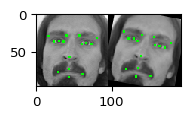

In [18]:
ia.imshow(
    np.hstack([
        # kpsoi.draw_on_image(img, size=2),
        # kpsoi_aug.draw_on_image(img_aug, size=2)
        KeypointsOnImage(y[0], shape=X[0].shape).draw_on_image(X[0], size=2),
        KeypointsOnImage(aug_y[0], shape=aug_X[0].shape).draw_on_image(aug_X[0], size=2)
    ])
)

In [71]:
# transformed images to save csv file
new_X = []
for img in aug_X:
    new_X.append(img[:, :, 0])
new_X = np.array(new_X).reshape(np.array(new_X).shape[0], -1)
print(new_X.shape)

(2140, 1, 9216)


In [70]:
# transformed annotations to save csv file
new_y = []
for anno in aug_y:
    new_y.append(KeypointsOnImage(anno, shape=X[0].shape).to_xy_array().reshape(-1))
new_y = np.array(new_y)
new_y.shape

(2140, 30)

In [81]:
columns = []
for col in df.columns:
    columns.append(col)

In [90]:
new_y_df = pd.DataFrame(data=new_y.astype('float64'), columns=columns[:-1])

ValueError: Must pass 2-d input

In [161]:
new_X_df = pd.DataFrame([], columns=['Image'], index=range(len(new_X)))

for i in range(len(new_X)):
    str_ = ""
    for j in range(new_X.shape[1]):
        str_ += "{} ".format(new_X[i, j])
    new_X_df.iloc[i, 0] = str_
    # new_X_df.iloc[i, 0] = np.array2string(new_X[i], separator=' ').replace("[", "").replace("]", "")

In [163]:
# np.fromstring(np.array2string(new_X[0], separator=' ').replace("[", "").replace("]", ""), sep=' ')
new_X_df.head()

,Image
0,0 0 0 0 0 0 0 0 219 233 233 233 236 237 235 23...
1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [164]:
new_df = pd.concat([new_y_df, new_X_df], axis=1)
new_df.to_csv('data/rotate_30.csv', index=False)

In [129]:
new_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,67.281868,42.562187,32.563641,33.429085,60.821957,42.007729,74.078896,44.820793,38.410000,35.509499,...,56.335720,54.978874,81.937477,23.431280,73.398087,38.698280,71.728630,36.391571,83.047722,0 0 0 ... 0 0 0
1,57.770973,29.200987,25.748238,41.814281,52.892868,31.709303,64.102531,27.710325,31.677923,40.169666,...,54.665874,67.398109,70.217728,47.821384,78.613838,56.026981,68.625137,61.111526,83.015480,0 0 0 ... 0 0 0
2,59.947910,29.841667,27.689295,41.058933,55.079552,33.028759,66.009995,29.227921,34.551342,40.167019,...,53.185131,68.463760,67.223129,42.777584,75.856079,54.740303,69.006882,57.521389,77.004723,0 0 0 ... 0 0 0
3,57.814331,29.818438,28.982950,46.285587,54.204647,34.028351,64.525085,27.274445,34.581966,44.806293,...,51.114044,75.716103,60.409245,51.835403,75.766724,61.138668,65.727150,66.286369,72.203415,0 0 0 ... 0 0 0
4,62.886795,33.538147,29.934103,43.810375,55.216343,36.320263,68.420158,31.811150,34.746754,43.184734,...,65.279671,70.119133,71.233009,42.226742,80.790276,54.050735,73.002014,57.847664,85.627754,0 0 0 ... 0 0 0


### Resize for imagenet  (only use once)

In [9]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Resize((226, 226)),
    iaa.Affine(rotate=(-30, 30))
])

In [10]:
X = gray_to_rgb(X)
y = arr_to_kps(y)
aug_X = []
aug_y = []
for i in range(X.shape[0]):
    aug_img, aug_kpsoi = seq(image=X[i], keypoints=y[i])
    aug_X.append(aug_img)
    aug_y.append(aug_kpsoi)

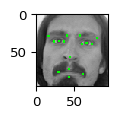

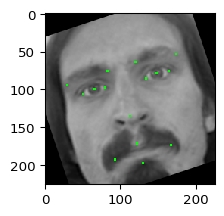

In [11]:
ia.imshow(KeypointsOnImage(y[0], shape=X[0].shape).draw_on_image(X[0], size=2))
ia.imshow(KeypointsOnImage(aug_y[0], shape=aug_X[0].shape).draw_on_image(aug_X[0], size=2))


In [12]:
new_X = []
for img in aug_X:
    new_X.append(img[:, :, 0])
new_X = np.array(new_X).reshape(np.array(new_X).shape[0], -1)
print(aug_X[0].shape)
print(new_X.shape)

(226, 226, 3)
(2140, 51076)


In [13]:
# transformed annotations to save csv file
new_y = []
for anno in aug_y:
    new_y.append(KeypointsOnImage(anno, shape=X[0].shape).to_xy_array().reshape(-1))
new_y = np.array(new_y)
new_y.shape

(2140, 30)

In [20]:
new_y[0]

array([146.70024 ,  79.28642 ,  64.816055, 100.20211 , 132.77379 ,
        85.53398 , 163.26947 ,  76.15987 ,  79.22533 ,  97.796196,
        50.409405, 107.410416, 118.995186,  63.79047 , 173.34938 ,
        53.58349 ,  81.620926,  76.18237 ,  28.79355 ,  95.408936,
       111.89458 , 135.73055 , 166.41982 , 174.3788  ,  91.73876 ,
       192.88976 , 121.24365 , 171.99316 , 129.44328 , 197.92229 ],
      dtype=float32)

In [14]:
columns = []
for col in df.columns:
    columns.append(col)

In [15]:
new_y_df = pd.DataFrame(data=new_y.astype('float64'), columns=columns[:-1])

In [16]:
new_X_df = pd.DataFrame([], columns=['Image'], index=range(len(new_X)))

for i in range(len(new_X)):
    str_ = ""
    for j in range(new_X.shape[1]):
        str_ += "{} ".format(new_X[i, j])
    new_X_df.iloc[i, 0] = str_
    # new_X_df.iloc[i, 0] = np.array2string(new_X[i], separator=' ').replace("[", "").replace("]", "")

In [17]:
new_df = pd.concat([new_y_df, new_X_df], axis=1)
new_df.to_csv('data/resized226_rotate_30.csv', index=False)

## shifting keypoints

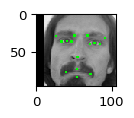

In [59]:
img_pad = ia.pad(img, left=10)
kpsoi_pad = kpsoi.shift(x=10)
ia.imshow(kpsoi_pad.draw_on_image(img_pad, size=2))

In [66]:
arr = kpsoi.to_xy_array()
print(arr.shape)
print(arr)
print(arr.reshape(-1))

(15, 2)
[[66.03356  39.002274]
 [30.227007 36.421677]
 [59.582077 39.647423]
 [73.13035  39.969997]
 [36.35657  37.3894  ]
 [23.452871 37.3894  ]
 [56.953262 29.033648]
 [80.22713  32.228138]
 [40.227608 29.002321]
 [16.356379 29.64747 ]
 [44.42057  57.066803]
 [61.19531  79.97017 ]
 [28.614496 77.38899 ]
 [43.312603 72.935455]
 [43.130707 84.48577 ]]
[66.03356  39.002274 30.227007 36.421677 59.582077 39.647423 73.13035
 39.969997 36.35657  37.3894   23.452871 37.3894   56.953262 29.033648
 80.22713  32.228138 40.227608 29.002321 16.356379 29.64747  44.42057
 57.066803 61.19531  79.97017  28.614496 77.38899  43.312603 72.935455
 43.130707 84.48577 ]
